# Determination of ratio D in Forward Field Calculation using Tesseroid with Linear Density

Our intention is to determine the ratio D needed to get an acceptable precission in the calculation of gravity fields using tesseroids with variable density that depends linearly on depth.

\begin{equation}
\rho(h) = a h + b
\end{equation}

In order to do this, we are going to take into account an spherical shell with inner and outer radii $R_1$ and $R_2$, respectivetly. We will perform the fields calculation for different values of D and compare them with the analytical solutions obtained in the "spherical_shell_variable_density" notebook:

\begin{equation}
V(r) = \pi Ga \frac{R_2^4 - R_1^4}{r} + \frac{4}{3}\pi G b\frac{R_2^3 - R_1^3}{r}
\end{equation}

We are going to test it with a thin and a thick spherical shell, of 1km and 35km of thickness, respectivetly.

Due to the nature of the numerical approximation of the tesseroid field by point masses located in the nodes of the GLQ, the fields can vary between computation points at the same height but at different longitude, latitude locations. Because of this we will evaluate the fields in a small grid and the comparison will be made by calculating the maximum difference between the analytical solution and these computation points.


**Import Packages**

In [1]:
from __future__ import division
import numpy as np
from tesseroid_density import tesseroid
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt

**Configuration for Pyplot Figures**

In [2]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

**Definition of linear density function**

We define a density function $\rho(h)$ that assumes a value of 2670 kg/m<sup>3</sup> at the Earth surface, and 3300 kg/m<sup>3</sup> at a depth of 35km from the surface. So, the density can be obtained as follows:

\begin{equation}
\rho(h) = -\frac{3300-2670}{35000} h + 2670
\end{equation}

If we want to write it as function of the radius spherical coordinate $r' = h + R$, where $R$ is the mean Earth radius, we can do it as follows:

\begin{equation}
\rho(r') = -\frac{3300-2670}{35000} r' + \left( \frac{3300-2670}{35000}R + 2670 \right)
\end{equation}



In [3]:
a = -(3300-2670)/35000.
b = (3300-2670)/35000.*MEAN_EARTH_RADIUS + 2670

def density_linear(height):
    r = height + MEAN_EARTH_RADIUS
    return a*r + b

**Definition of spherical shell analytical solutions**

In [4]:
def shell_linear_density(height, top, bottom, a, b):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = np.pi*G*a*(r2**4 - r1**4) + 4/3.*np.pi*G*b*(r2**3 - r1**3)
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

## Thin spherical shell (1km)
**Definition of Spherical Shell and Tesseroid Model**

In [5]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [density_linear for i in range(model.size)])

**Determination of D for different grids**

In [6]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_linear_density(heights[0], top, bottom, a, b)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/Dlinear/' + field + '-' + grid + '-differences.npz',
                 D_values=D_values, diffs=diffs)

tesseroid_density/tesseroid.py:234: RuntimeWarning: Stopped dividing a tesseroid because it's dimensions would be below the minimum numerical threshold (1e-6 degrees or 1e-3 m). Will compute without division. Cannot guarantee the accuracy of the solution.
  warnings.warn(warning_msg, RuntimeWarning)


**Plot results**

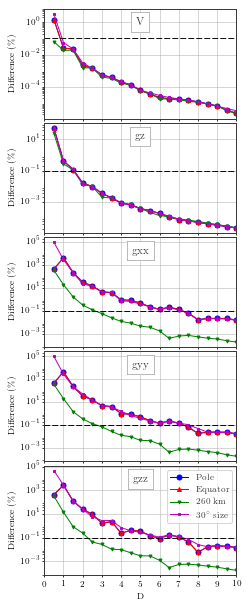

In [9]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = '$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/Dlinear/' + field + '-' + 
                        grid + '-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([0, 10], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

These results show that the size-distance ratio D must be equal to 1, 2 and 8 for the potential, gradient and tensor components, respectivetly.

## Thick spherical shell (35km)
**Definition of Spherical Shell and Tesseroid Model**

In [11]:
top, bottom = 0, -350000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [density_linear for i in range(model.size)])

**Determination of D for different grids**

In [12]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_linear_density(heights[0], top, bottom, a, b)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/Dlinear/' + field + '-' + 
                 grid + '-thick-differences.npz',
                 D_values=D_values, diffs=diffs)

**Plot results**

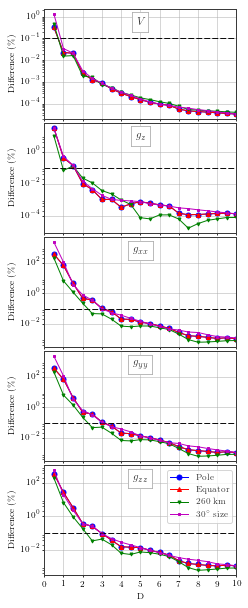

In [15]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = '$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/Dlinear/' + field + '-' + 
                        grid + '-thick-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([0, 10], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

These result show that the required values of D for a thick shell are lower or equal as the ones needed for the thin shell. We are going to be conservative about the choice of D and keep the maximum values of D.

## Decreasing density with depth

Although it seems there are not many practical applications in which density decreases with depth, we are going to perform a test comparing a spherical shell model with such kind of density.
To be conservative, we will choose a thin shell of 1km.

**Definition of linear density function**

In [16]:
a_decreasing = 1
b_decreasing = 0

def decreasing_density(height):
    r = height + MEAN_EARTH_RADIUS
    return a_decreasing*r + b_decreasing

**Definition of Spherical Shell and Tesseroid Model**

In [17]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [decreasing_density for i in range(model.size)])

**Determination of D for different grids**

In [18]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gxx gyy gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_linear_density(heights[0],
                                          top, bottom,
                                          a_decreasing,
                                          b_decreasing)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights,
                                               model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/Dlinear/' + field + '-' + 
                 grid + '-decreasing-differences.npz',
                 D_values=D_values, diffs=diffs)

**Plot results**

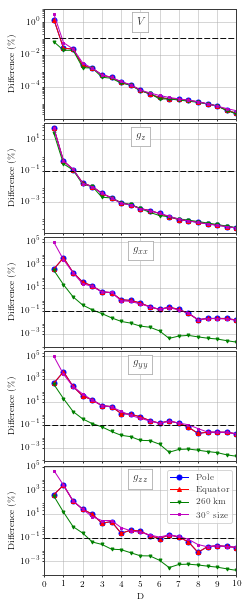

In [20]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gxx gyy gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = '$V$ $g_z$ $g_{xx}$ $g_{yy}$ $g_{zz}$'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 8.33))
fig.subplots_adjust(hspace=0)
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/Dlinear/' + field + '-' +
                        grid + '-decreasing-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([0, 10], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()

## Variation of D with height

Now we are going to get the variation of D with the height of the computation grid in the calculation of the gzz. Because the thin shell offers the more conservative solutions of D, we are going to perform the calculation using this shell.

**Definition of Spherical Shell and Tesseroid Model**

In [16]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [density_linear for i in range(model.size)])

**Determination of D for different heights**

In [17]:
shape = (10, 10)
zs = [2e3, 10e3, 50e3, 260e3]
D_values = np.arange(0.5, 10.5, 0.5)
field = 'gzz'

for z in zs:
    lons, lats, heights = gridder.regular((60, 90, 0, 30), shape, z=z)
    analytical = shell_linear_density(heights[0], top, bottom, a, b)
    diffs = []
    for D in D_values:
        result = getattr(tesseroid, field)(lons, lats, heights,
                                           model, ratio=D)
        diff = np.abs(result - analytical[field])/np.abs(analytical[field])
        diff = 100*np.max(diff)
        diffs.append(diff)
    diffs = np.array(diffs)
    np.savez('results/D-vs-height/' + field + '-' + 
             '{:.0f}'.format(z/1e3) + '-differences.npz',
             D_values=D_values, diffs=diffs)

**Plot results**

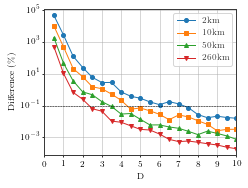

In [18]:
zs = [2e3, 10e3, 50e3, 260e3]
markers = ["o", "s", "^", "v", "D", "p"]
field = 'gzz'

fig, ax = plt.subplots()
fig.set_size_inches((3.33, 2.5))
for z, m in zip(zs, markers):
    diffs = np.load('results/D-vs-height/' + field + '-' +
                    '{:.0f}'.format(z/1e3) + '-differences.npz')
    D_values, diff = diffs['D_values'], diffs['diffs']
    ax.plot(D_values, diff, '-', marker=m,
            label='{:.0f}'.format(z/1e3) + 'km')

ax.plot([0, 10], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
ax.set_yscale('log')
ax.set_yticks(ax.get_yticks()[2:-2])
ax.set_ylabel('Difference (\%)')
ax.grid(True, linewidth=0.5, color='#aeaeae')
ax.set_axisbelow(True)
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
plt.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.show()